# Music genre classification using fast.ai

Recently Kaggle grandmaster, Rob conducted a challenge to classify music according to what genre it was.
Using a CNN, as taught in lesson 1 of fast.ai 

The data provided are over 20,000 royalty free song samples (30 second clips) and their musical genres. Your task is to create a machine learning algorithm capable of predicting the genres of unlabeled music files. Create features, design architectures, do whatever it takes to predict them the best.

In [1]:
! pip install -Uqq kaggle git+https://github.com/huggingface/huggingface_hub#egg=huggingface-hub["fastai"]

In [2]:
from fastai.data.all import *
from fastai.imports import *
from fastai.vision.all import *

from huggingface_hub import push_to_hub_fastai

/opt/conda/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")


## Collecting Data

[Note from Jeremy on downloading data from kaggle](https://www.kaggle.com/code/jhoward/getting-started-with-nlp-for-absolute-beginners)

In [4]:
creds = ""

from pathlib import Path

cred_path = Path("~/.kaggle/kaggle.json").expanduser()
if not cred_path.exists():
    cred_path.parent.mkdir(exist_ok=True)
    cred_path.write_text(creds)
    cred_path.chmod(0o600)

In [5]:
path = Path("input/kaggle-pog-series-s01e02")
path.ls()

(#6) [Path('input/kaggle-pog-series-s01e02/genres.csv'),Path('input/kaggle-pog-series-s01e02/sample_submission.csv'),Path('input/kaggle-pog-series-s01e02/test.csv'),Path('input/kaggle-pog-series-s01e02/test'),Path('input/kaggle-pog-series-s01e02/train.csv'),Path('input/kaggle-pog-series-s01e02/train')]

In [10]:
from zipfile import ZipFile
from kaggle import api

if not path.exists():
    api.competition_download_cli(str(path))
    ZipFile(f"{path}.zip").extractall(path)

100%|██████████| 9.05G/9.05G [07:54<00:00, 20.5MB/s]

In [12]:
! kaggle datasets download -d dienhoa/music-genre-spectrogram-pogchamps

100%|█████████████████████████████████████▉| 6.80G/6.80G [07:00<00:00, 14.7MB/s]
100%|██████████████████████████████████████| 6.80G/6.80G [07:00<00:00, 17.4MB/s]


## Quick EDA

In [17]:
df_train = pd.read_csv("input/kaggle-pog-series-s01e02/train.csv")
df_train.head()

song_id    filename          filepath  genre_id                genre
0    10150  010150.ogg  train/010150.ogg         7         Instrumental
1     7358  007358.ogg  train/007358.ogg         2                 Punk
2    20573  020573.ogg  train/020573.ogg         5                 Folk
3    11170  011170.ogg  train/011170.ogg        12  Old-Time / Historic
4    16662  016662.ogg  train/016662.ogg         1                 Rock

In [18]:
df_train["filepath"] = df_train["filepath"].str.replace("ogg", "png")

In [19]:
df_train["genre"].value_counts()

Rock                   3097
Electronic             3073
Punk                   2584
Experimental           1801
Hip-Hop                1761
Folk                   1215
Chiptune / Glitch      1181
Instrumental           1045
Pop                     945
International           814
Ambient Electronic      796
Classical               495
Old-Time / Historic     408
Jazz                    306
Country                 142
Soul-RnB                 94
Spoken                   94
Blues                    58
Easy Listening           13
Name: genre, dtype: int64

In [20]:
df_train.head()

song_id    filename          filepath  genre_id                genre
0    10150  010150.ogg  train/010150.png         7         Instrumental
1     7358  007358.ogg  train/007358.png         2                 Punk
2    20573  020573.ogg  train/020573.png         5                 Folk
3    11170  011170.ogg  train/011170.png        12  Old-Time / Historic
4    16662  016662.ogg  train/016662.png         1                 Rock

In [21]:
df_train = df_train.set_index("song_id")

In [22]:
df_train = df_train.drop(
    [
        23078,
        3137,
        4040,
        15980,
        11088,
        9963,
        24899,
        16312,
        22698,
        17940,
        22295,
        3071,
        13954,
    ]
)

In [23]:
df_train.shape

(19909, 4)

## Fastai Dataloading

**1. Using DataBlock and loading images**

In [14]:
path = Path("input/music-genre-spectrogram-pogchamps/spectograms/")

In [15]:
dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    splitter=ColSplitter(),
    get_x=lambda o: f"{path}/" + o.path,
    get_y=lambda o: o.genre,
    item_tfms=Resize(224),
    batch_tfms=aug_transforms(),
)

In [13]:
temp_train = df_train
temp_train.loc[:15000, "is_valid"] = True
temp_train.loc[15000:, "is_valid"] = False

In [14]:
dls = dblock.dataloaders(temp_train)

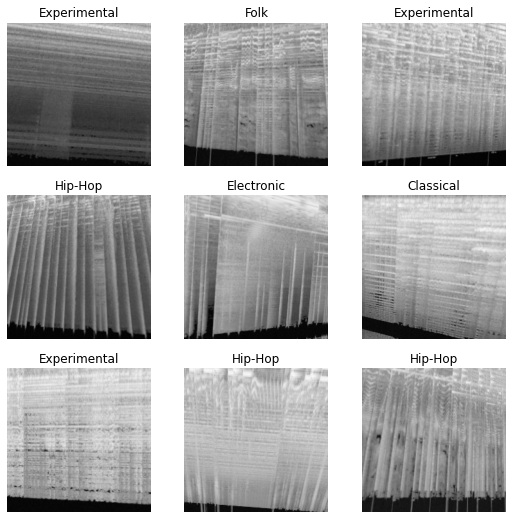

In [16]:
dls.show_batch()

In [17]:
# dblock.summary(df_train)

**2. Using DataLoaders methods with loading from dataframe method**

Hoping this will solve issue of Pickling. Label_col is the sixth element in this dataframe.

In [24]:
df_train.head()

filename          filepath  genre_id                genre
song_id                                                             
10150    010150.ogg  train/010150.png         7         Instrumental
7358     007358.ogg  train/007358.png         2                 Punk
20573    020573.ogg  train/020573.png         5                 Folk
11170    011170.ogg  train/011170.png        12  Old-Time / Historic
16662    016662.ogg  train/016662.png         1                 Rock

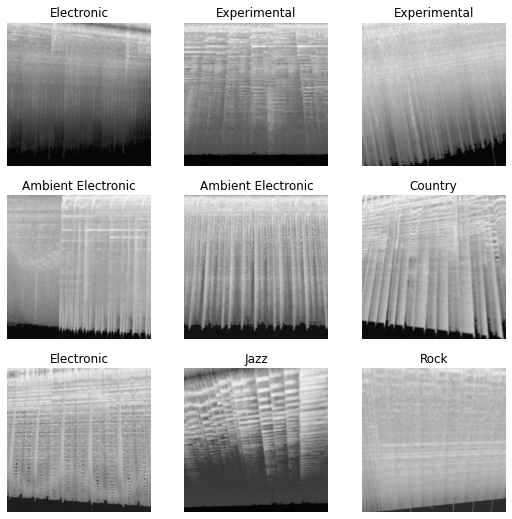

In [28]:
dls = ImageDataLoaders.from_df(
    df_train,
    path,
    valid_pct=0.2,
    seed=34,
    y_block=CategoryBlock,
    item_tfms=Resize(460),
    batch_tfms=aug_transforms(size=224),
    fn_col=1,
    label_col=3,
)
dls.show_batch()

## Training fastai model

In [29]:
learn = vision_learner(dls, resnet50, metrics=error_rate)

SuggestedLRs(valley=0.0008317637839354575)

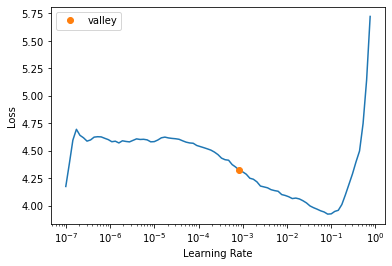

In [30]:
learn.lr_find()

In [31]:
learn.fine_tune(10, 0.0008317637839354575)

In [32]:
learn.export("model.pkl")

## Pushing models

In [33]:
push_to_hub_fastai(
    learn,
    "kurianbenoy/music_genre_classification_baseline",
    commit_message="Resnet50 with 10 epochs of training",
)

/home/kurianbenoy/music_genre_classification_baseline is already a clone of https://huggingface.co/kurianbenoy/music_genre_classification_baseline. Make sure you pull the latest changes with `repo.git_pull()`.


Upload file model.pkl:   0%|          | 32.0k/98.4M [00:00<?, ?B/s]

To https://huggingface.co/kurianbenoy/music_genre_classification_baseline
   390320d..3605083  main -> main



'https://huggingface.co/kurianbenoy/music_genre_classification_baseline/commit/360508311005aefeb3ca29933f2173202afe4f30'

## Taking a look at results

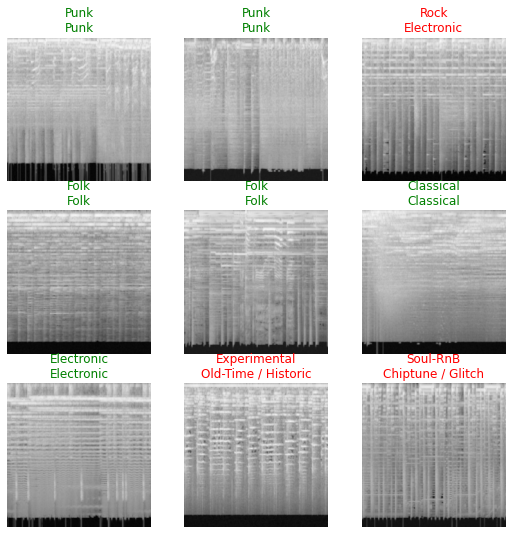

In [36]:
learn.show_results()

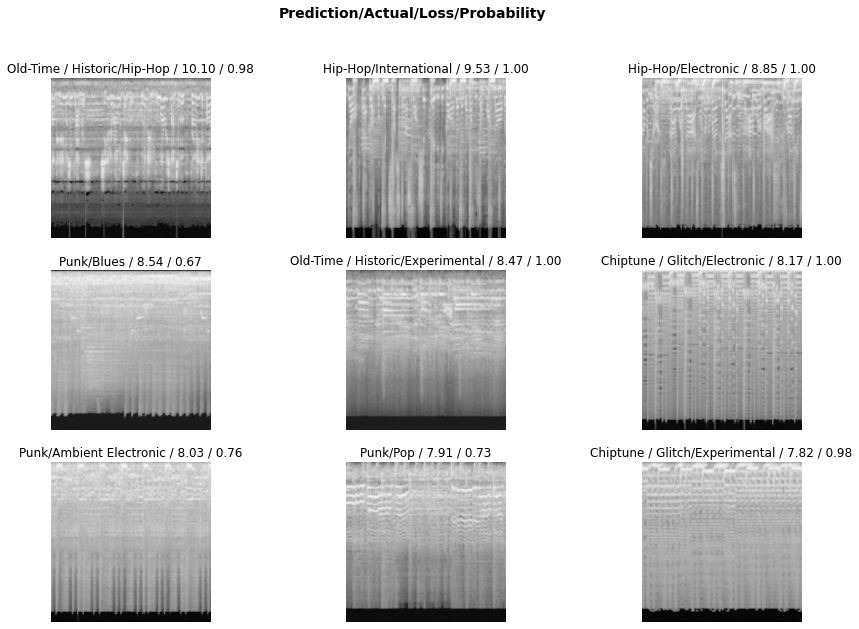

In [37]:
interp = Interpretation.from_learner(learn)
interp.plot_top_losses(9, figsize=(15, 10))